# **Assignment 2: Predicting Fake Job Postings**

In [1]:
import re
import os
import sys
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.tree import DecisionTreeClassifier



In [3]:
import tensorflow as tf

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

## **Data Exploration**

In [4]:
dataset_path = './fake_job_postings.csv'

df = pd.read_csv(dataset_path, encoding='utf-8')
df = df.replace([pd.NA, 'NaN', 'nan', 'NULL', 'Null', 'null', '', r'\s+\s*'], np.nan)


In [5]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
# Check the column types, to make sure the dataset was properly loaded

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [7]:
# Class Distribution

classes = df['fraudulent'].value_counts().keys().to_list()
print(f'{len(classes)} classes:\n{classes[0]} (real)\n{classes[1]} (fake)\n')

total_records = df.shape[0]
real = df.loc[df['fraudulent'] == 0].count()[0]
print(f'Class rate:\n{classes[0]}: {round(real/total_records*100)}%\n{classes[1]}: {round((1-real/total_records)*100)}%\n')

categorical_features = ['department', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
                        'required_experience', 'required_education', 'industry', 'function']
print(f'Categorical features:\n{", ".join(categorical_features)}\n')

# string_features = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
string_features = ['company_profile', 'description', 'requirements', 'benefits']
print(f'String features:\n{", ".join(string_features)}\n')

2 classes:
0 (real)
1 (fake)

Class rate:
0: 95%
1: 5%

Categorical features:
department, telecommuting, has_company_logo, has_questions, employment_type, required_experience, required_education, industry, function

String features:
company_profile, description, requirements, benefits



We observe that there is a huge imbalance between the number of records which correspond to each class that can lead to a huge bias in favour of the real job postings since they comprise 95% of our dataset.

## **Prepare the Data**

In [8]:
# Check for null values

pd.DataFrame({'null_count': df.isnull().sum(), 'null_percentage': round(df.isnull().sum() * 100 / df.shape[0],2)})

,null_count,null_percentage
job_id,0,0.00
title,0,0.00
location,346,1.94
department,11547,64.58
salary_range,15012,83.96
company_profile,3308,18.50
description,1,0.01
requirements,2695,15.07
benefits,7210,40.32
telecommuting,0,0.00


We notice that there are many records in this dataset contain NULL values for some features.

In [9]:
# Check the exact number of rows with at least one null value.

df.shape[0] - df.dropna().shape[0]

17106

## **Pre-processing** - **Removing all records with null** **values**

Prepare the data:

1. Encode the label column and delete invalid data in the label (fraudulent) column. Delete any rows that contain fraudulent values other than 0 or 1.

2. List the missing values per attribute and their percentages. Deal with the attributes that contain too many null values. (Delete any attributes that have more than 1% null values.)

3. Clean the datasets: remove anything that is not a letter, remove multiple spaces, lower case everything.

4. The data is highly unbalanced. You need to remedy this before you attempt to create a model. There is a function in pySpark called sampleby that will help you accomplish this. Undersample the majority class.

5. Split text into words, remove stopwords, and convert text into vectors (your choice of encoding). Help: feature extractors and feature transformers .
Perform a random split (70%,30%) of the data into training and test.

In [26]:
# Removing all records which contain null values in at least one feature.

df_new = df.dropna(how='any', subset=categorical_features+string_features+['salary_range'], axis=0)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774 entries, 6 to 17865
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               774 non-null    int64  
 1   title                774 non-null    object 
 2   location             774 non-null    object 
 3   department           774 non-null    float64
 4   salary_range         774 non-null    object 
 5   company_profile      774 non-null    object 
 6   description          774 non-null    object 
 7   requirements         774 non-null    object 
 8   benefits             774 non-null    object 
 9   telecommuting        774 non-null    int64  
 10  has_company_logo     774 non-null    int64  
 11  has_questions        774 non-null    int64  
 12  employment_type      774 non-null    float64
 13  required_experience  774 non-null    float64
 14  required_education   774 non-null    float64
 15  industry             774 non-null    f

In [27]:
# Removes characters which correspond to digits
def remove_digits(text):
    text = re.sub(r'[0-9]', ' ', text)
    return text

# Removes non-alphanumeric characters
def remove_non_alpanumeric(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return text

# Removes non-english letter characters
def remove_non_letters(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    return text

# Remove any non-words
def remove_non_words(text):
    text = re.sub('[\W_]+', ' ', text)
    return text

# Removes words which contain numerical digits between letters
def remove_words_with_numbers(text):
    text = re.sub(r'\w*\d\w*', ' ', text)
    return text

# Removes hyperlinks
def remove_hyperlinks(text):
    text = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-])', ' ', text)
    return text

# Removes all HTML tags
def remove_html_tags(text):
    text = re.sub('<[^>]+>', ' ', text)
    return text

# Replaces contractions with the full words (e.g. I'll --> I will)
def expand_contractions(text, contractions_re, contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
    

In [28]:
# Preprocesses (cleans) text by performing the following operations:
    # Converting text to lowercase
    # Expanding contractions
    # Removing URLs
    # Removing non-alphanumeric characters
    # Removing non-digit characters
    # Removing tabs and redundant whitespaces
    # Performing stemming
    # Performing lemmatization
    # Replacing the empty strings and NULL entries (before and after preprocessing), with the string "emptystring"

def text_preprocess(text, contractions_re, contractions_dict, stopwords=None, lemmatizer=None, stemmer=None):
    if text and text is not np.nan and text.lower() != 'nan':
        text = text.lower()
        text = remove_hyperlinks(text)
        text = remove_html_tags(text)
        text = expand_contractions(text, contractions_re, contractions_dict)
        text = remove_non_letters(text)
        tokens = nltk.word_tokenize(text)
        
        if not tokens:
            text = 'emptystring'
        
        else:
            if stemmer:
                tokens = [stemmer.stem(token) for token in tokens]
            
            if lemmatizer:
                tokens = [lemmatizer.lemmatize(token) for token in tokens]
            tokens = [x for x in tokens if x not in set(stopwords)]
            text = ' '.join(tokens)
            
            if not text or len(text) < 2:
                text = 'emptystring'
        
    return text


In [29]:
# Download NLTK tools
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initializes stop words, stemmer and lemmatizer
stop_words = set(stopwords.words('english')+list(STOPWORDS)+list(ENGLISH_STOP_WORDS))
lemmatizer = WordNetLemmatizer()

# Dictionary with contractions
contractions_dict = {"ain't": "are not", "'s":" is", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "‘cause": "because", 
                     "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", 
                     "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", 
                     "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "how'd": "how did", "how'd'y": "how do you", 
                     "how'll": "how will", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", 
                     "I've": "I have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", 
                     "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", 
                     "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", 
                     "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                     "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                     "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "that'd": "that would", 
                     "that'd've": "that would have", "there'd": "there would", "there'd've": "there would have", "they'd": "they would", 
                     "they'd've": "they would have","they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                     "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                     "we're": "we are", "we've": "we have", "weren't": "were not","what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                     "what've": "what have", "when've": "when have", "where'd": "where did", "where've": "where have", "who'll": "who will", 
                     "who'll've": "who will have", "who've": "who have", "why've": "why have", "will've": "will have", "won't": "will not", 
                     "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                     "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", 
                     "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# Regular expression to identify contractions
contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# Replacing null values with the most common value in the respective fields

def replace_null(df, categorical_features):
    df_new = df.copy()
    
    for c in categorical_features:        
        df_new.loc[df_new['fraudulent'] == 0, [c]] = df_new.loc[df_new['fraudulent'] == 0, [c]].fillna(df_new.loc[df_new['fraudulent'] == 0, c].mode()[0])
        df_new.loc[df_new['fraudulent'] == 1, [c]] = df_new.loc[df_new['fraudulent'] == 1, [c]].fillna(df_new.loc[df_new['fraudulent'] == 1, c].mode()[0])
    
    return df_new


In [31]:
# Transforming categorical string fields to numerical

def cat2num(df, categorical_features):
    df_new = df.copy()
    
    for c in categorical_features:
        
        if df_new[c].dtype != np.int64:
            df_new.loc[:,[c]] = LabelEncoder().fit_transform(df_new[c].astype("category").cat.codes)
            df_new[c].replace(0, np.nan, inplace=True)
    
    return df_new

In [32]:
# Applying string preprocessing to the specified fields by appling the text preprocessing function 
# to the dataframe features that are contained in string_features list

def clean_strings(df, string_features):
    df_new = df.copy()
    
    for c in string_features:
        df_new.loc[:,[c]] = df_new[df_new[c].astype(str) != 'nan'][c].apply(lambda x: text_preprocess(str(x), contractions_re, contractions_dict, stop_words, lemmatizer)).astype(str)
    
    return df_new

In [35]:
#  Performing some text preprocessing on the string features of the records that remain
# Download NLTK tools

import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

df_new = clean_strings(df_new, string_features)

salary = df_new['salary_range'].str.split('-', n=1, expand=True)
salary[0] = pd.to_numeric(salary[0], errors='coerce')
salary[1] = pd.to_numeric(salary[1], errors='coerce')
df_new['min_salary'] = salary[0].astype(float)
df_new['max_salary'] = salary[1].astype(float)

df_new.describe()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,job_id,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,7.740000e+02,7.740000e+02
mean,8664.093023,686.856589,0.094315,0.978036,0.673127,2.027132,3.852713,4.184755,57.157623,19.093023,0.093023,1.731337e+06,2.658515e+06
std,5014.106692,349.137620,0.292456,0.146660,0.469374,0.455568,2.188766,2.998615,29.994022,9.349703,0.290653,3.388751e+07,5.180494e+07
min,7.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00
25%,4483.500000,380.000000,0.000000,1.000000,0.000000,2.000000,1.000000,2.000000,27.000000,13.000000,0.000000,2.400000e+04,3.120000e+04
50%,8542.000000,734.500000,0.000000,1.000000,1.000000,2.000000,3.000000,2.000000,59.000000,19.000000,0.000000,4.000000e+04,5.450000e+04
75%,12922.250000,1055.000000,0.000000,1.000000,1.000000,2.000000,6.000000,5.000000,76.000000,26.000000,0.000000,6.500000e+04,9.000000e+04
max,17866.000000,1330.000000,1.000000,1.000000,1.000000,5.000000,7.000000,13.000000,131.000000,37.000000,1.000000,8.000000e+08,1.200000e+09


We observe that half the records are from the original dataset and that the class imbalance situtation got decremented from 95% - 5% to 98% - 2%. Checking if there exist any outliers in the data by considering the salary range feature.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Salary'),
 Text(0.5, 1.0, 'Maximum salary in fake job postings')]

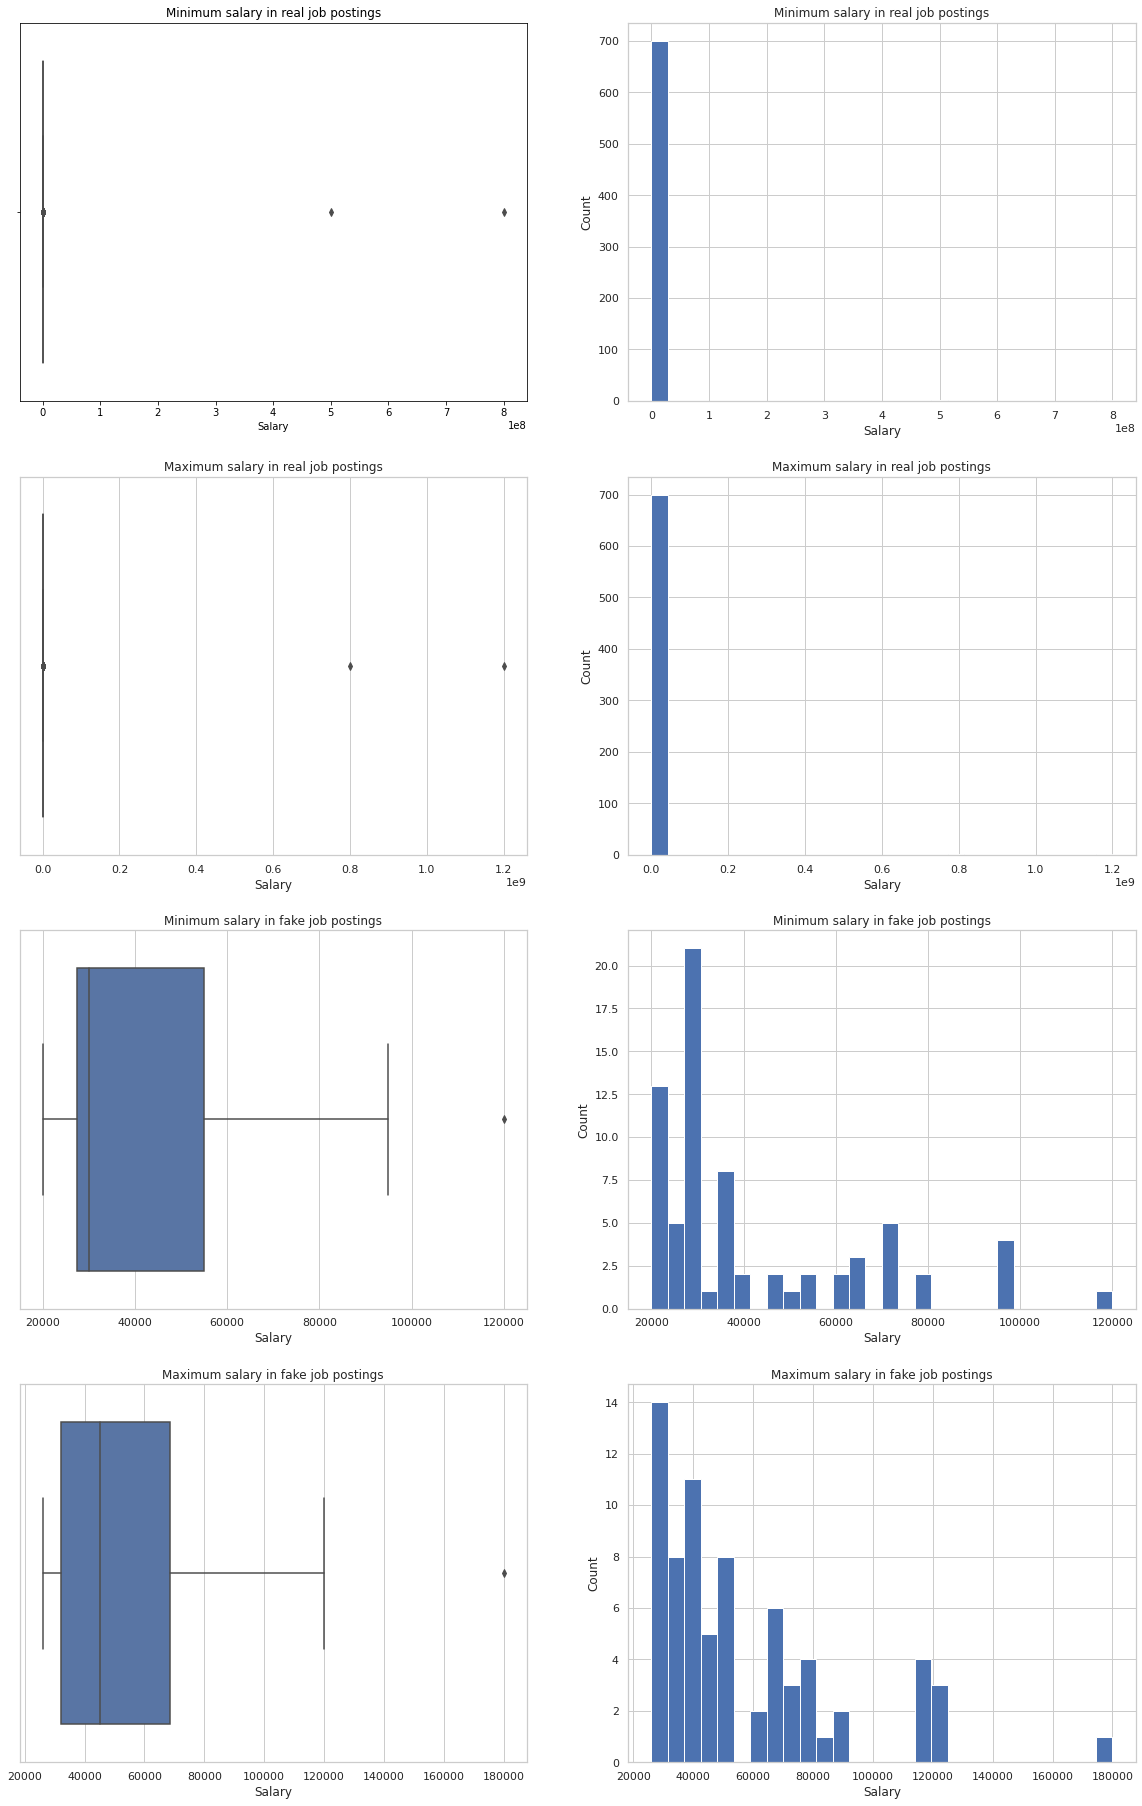

In [36]:
# Plotting the data

fig, ax = plt.subplots(4, 2, figsize=(20,32))

plt.subplot(4, 2, 1)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 0, 'min_salary']).set(xlabel='Salary', title='Minimum salary in real job postings')

plt.subplot(4, 2, 2)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 0, 'min_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Minimum salary in real job postings')

plt.subplot(4, 2, 3)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 0, 'max_salary']).set(xlabel='Salary', title='Maximum salary in real job postings')

plt.subplot(4, 2, 4)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 0, 'max_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Maximum salary in real job postings')

plt.subplot(4, 2, 5)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 1, 'min_salary']).set(xlabel='Salary', title='Minimum salary in fake job postings')

plt.subplot(4, 2, 6)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 1, 'min_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Minimum salary in fake job postings')

plt.subplot(4, 2, 7)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 1, 'max_salary']).set(xlabel='Salary', title='Maximum salary in fake job postings')

plt.subplot(4, 2, 8)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 1, 'max_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Maximum salary in fake job postings')
    

In [37]:
# Removing outliers

q1, q3 = np.percentile(df_new.loc[df_new['fraudulent'] == 0, 'min_salary'].dropna(), [25 ,75])
iqr = q3 - q1
minminreal = max(0,q1-1.5*iqr)
maxminreal = max(0,q3+1.5*iqr)

q1, q3 = np.percentile(df_new.loc[df_new['fraudulent'] == 0, 'max_salary'].dropna(), [25 ,75])
iqr = q3 - q1
minmaxreal = max(0,q1-1.5*iqr)
maxmaxreal = max(0,q3+1.5*iqr)

q1, q3 = np.percentile(df_new.loc[df_new['fraudulent'] == 1, 'min_salary'].dropna(), [25 ,75])
iqr = q3 - q1
minminfake = max(0,q1-1.5*iqr)
maxminfake = max(0,q3+1.5*iqr)

q1, q3 = np.percentile(df_new.loc[df_new['fraudulent'] == 1, 'max_salary'].dropna(), [25 ,75])
iqr = q3 - q1
minmaxfake = max(0,q1-1.5*iqr)
maxmaxfake = max(0,q3+1.5*iqr)


In [38]:
df_new.loc[(df_new['fraudulent'] == 0) & (df_new['min_salary'] < minminreal), ['min_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 0) & (df_new['min_salary'] > maxminreal), ['min_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 0) & (df_new['max_salary'] < minmaxreal), ['max_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 0) & (df_new['max_salary'] > maxmaxreal), ['max_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 1) & (df_new['min_salary'] < minminfake), ['min_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 1) & (df_new['min_salary'] > maxminfake), ['min_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 1) & (df_new['max_salary'] < minmaxfake), ['max_salary']] = np.nan
df_new.loc[(df_new['fraudulent'] == 1) & (df_new['max_salary'] > maxmaxfake), ['max_salary']] = np.nan

df_new = df_new.dropna(how='any', subset=['min_salary', 'max_salary'], axis=0)

In [39]:
df_new.describe()

,job_id,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,min_salary,max_salary
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,8612.451389,681.920833,0.098611,0.976389,0.668056,2.029167,3.809722,4.225000,56.320833,19.205556,0.098611,40383.070833,57402.252778
std,5043.050498,353.179535,0.298346,0.151940,0.471239,0.472303,2.195878,3.059346,29.814188,9.430042,0.298346,25862.804109,36469.726350
min,7.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4402.500000,380.000000,0.000000,1.000000,0.000000,2.000000,1.000000,2.000000,27.000000,13.000000,0.000000,22000.000000,30000.000000
50%,8556.500000,711.000000,0.000000,1.000000,1.000000,2.000000,3.000000,2.000000,59.000000,19.000000,0.000000,35000.000000,50000.000000
75%,12934.250000,1055.000000,0.000000,1.000000,1.000000,2.000000,6.000000,5.000000,73.000000,27.000000,0.000000,52000.000000,80000.000000
max,17866.000000,1330.000000,1.000000,1.000000,1.000000,5.000000,7.000000,13.000000,127.000000,37.000000,1.000000,125000.000000,180000.000000


In [40]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 6 to 17865
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   job_id               720 non-null    int64  
 1   title                720 non-null    object 
 2   location             720 non-null    object 
 3   department           720 non-null    float64
 4   salary_range         720 non-null    object 
 5   company_profile      720 non-null    object 
 6   description          720 non-null    object 
 7   requirements         720 non-null    object 
 8   benefits             720 non-null    object 
 9   telecommuting        720 non-null    int64  
 10  has_company_logo     720 non-null    int64  
 11  has_questions        720 non-null    int64  
 12  employment_type      720 non-null    float64
 13  required_experience  720 non-null    float64
 14  required_education   720 non-null    float64
 15  industry             720 non-null    f

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/li

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Salary'),
 Text(0.5, 1.0, 'Maximum salary in fake job postings')]

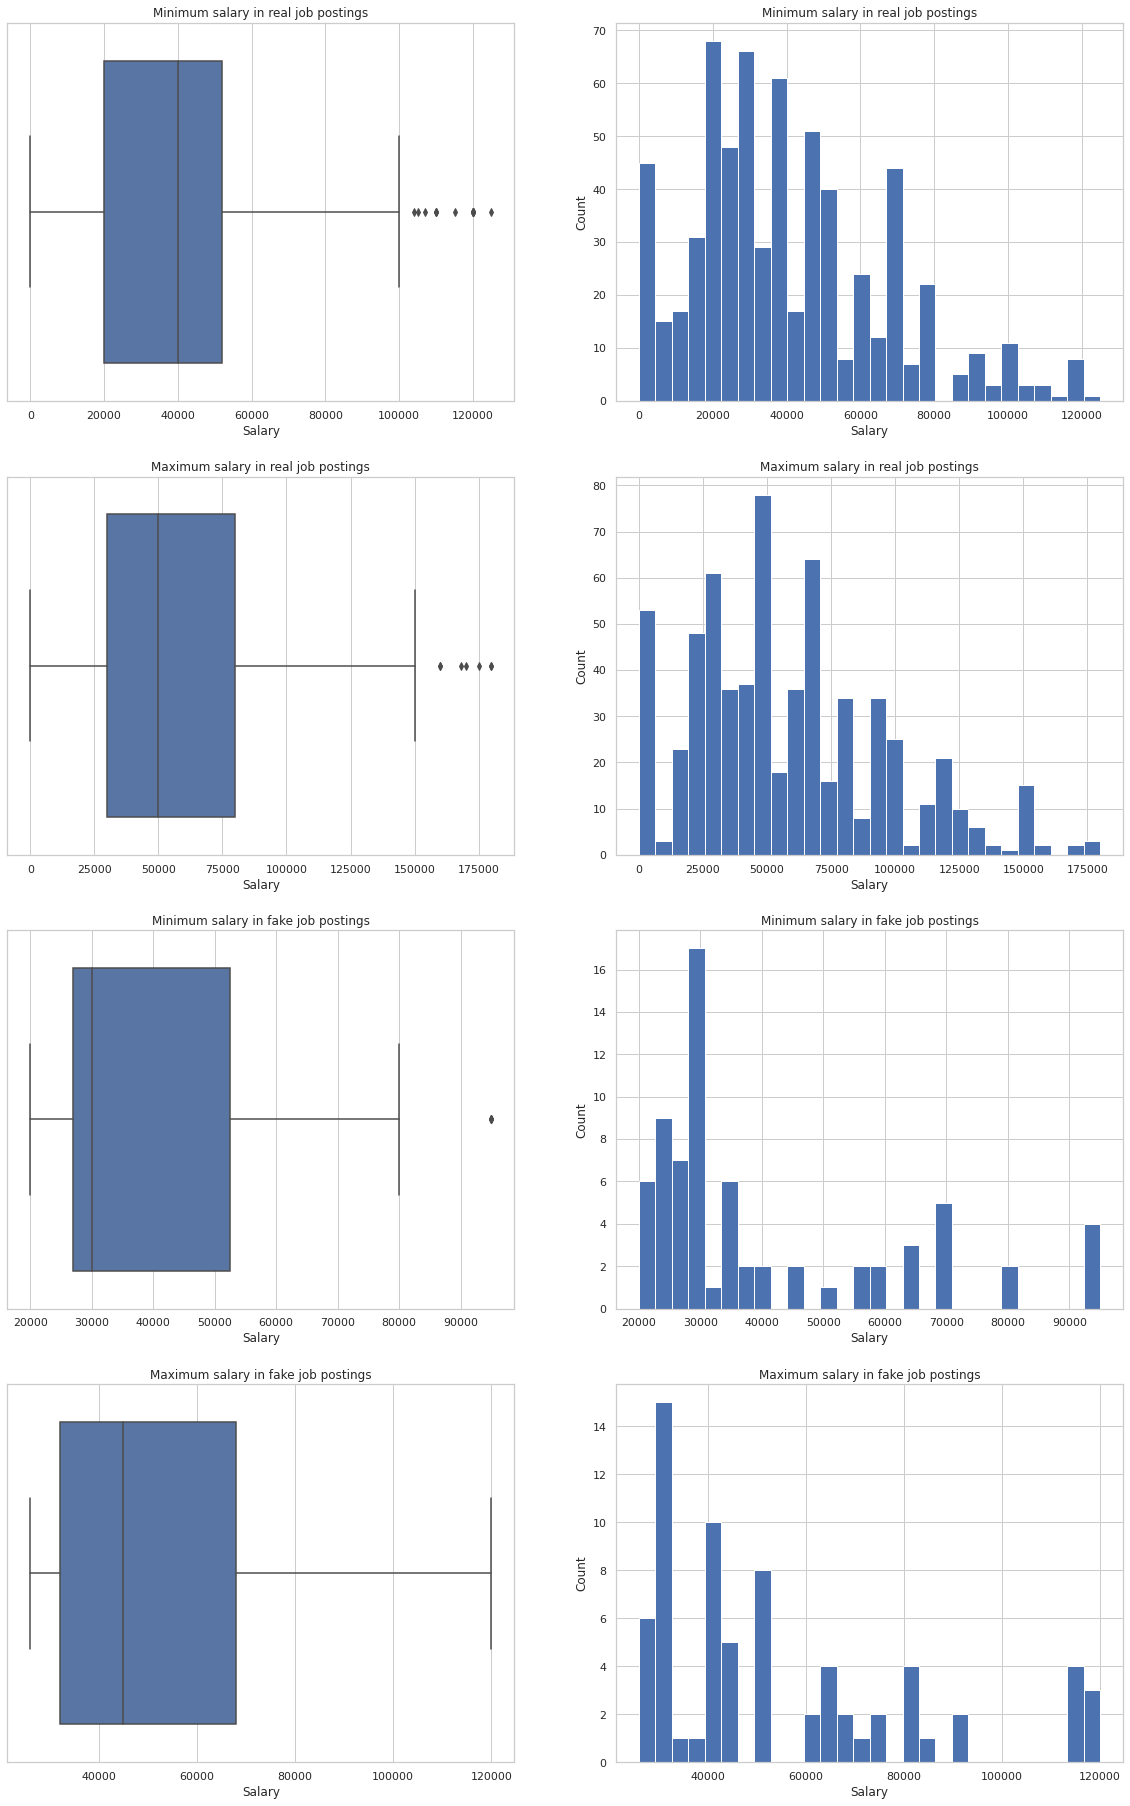

In [41]:
# Plotting the Data after removing outliers

fig, ax = plt.subplots(4, 2, figsize=(20,32))

plt.subplot(4, 2, 1)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 0, 'min_salary']).set(xlabel='Salary', title='Minimum salary in real job postings')

plt.subplot(4, 2, 2)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 0, 'min_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Minimum salary in real job postings')

plt.subplot(4, 2, 3)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 0, 'max_salary']).set(xlabel='Salary', title='Maximum salary in real job postings')

plt.subplot(4, 2, 4)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 0, 'max_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Maximum salary in real job postings')

plt.subplot(4, 2, 5)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 1, 'min_salary']).set(xlabel='Salary', title='Minimum salary in fake job postings')

plt.subplot(4, 2, 6)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 1, 'min_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Minimum salary in fake job postings')

plt.subplot(4, 2, 7)
sns.set(style='whitegrid')
sns.boxplot(df_new.loc[df_new['fraudulent'] == 1, 'max_salary']).set(xlabel='Salary', title='Maximum salary in fake job postings')

plt.subplot(4, 2, 8)
sns.set(style='whitegrid')
sns.distplot(df_new.loc[df_new['fraudulent'] == 1, 'max_salary'], norm_hist=False, kde=False, bins=28, hist_kws={"alpha": 1}).\
    set(xlabel='Salary', ylabel='Count', title='Maximum salary in fake job postings')

In [42]:
# Checking the Class Distribution after dropping the records

total_records = df_new.shape[0]
print(f'{total_records} records\n')

classes = df_new['fraudulent'].value_counts().keys().to_list()
print(f'{len(classes)} classes:\n{classes[0]} (real)\n{classes[1]} (fake)\n')

total_records = df_new.shape[0]
real = df_new.loc[df_new['fraudulent'] == 0].count()[0]
print(f'Class rate:\n{classes[0]}: {round(real/total_records*100)}%\n{classes[1]}: {round((1-real/total_records)*100)}%\n')


720 records

2 classes:
0 (real)
1 (fake)

Class rate:
0: 90%
1: 10%



The class imbalance situtation is improved from 95% - 5% to 90% - 10%. We are now left with less than 10% of the number of records in the original dataset. 

In [43]:
transformer = FeatureUnion(transformer_list=[
                ('profile_tfidf', Pipeline([
                    ('extract_text', FunctionTransformer(lambda x: x['company_profile'], validate=False)),
                    ('tfidf', TfidfVectorizer(token_pattern=r'\w{2,}', ngram_range=(1, 3), max_df=0.34, min_df=0.001)),
                    ])),
                ('profile_count', Pipeline([
                    ('extract_text', FunctionTransformer(lambda x: x['company_profile'], validate=False)),
                    ('count', CountVectorizer(token_pattern=r'\w{2,}', ngram_range=(1, 3), max_df=0.34, min_df=0.001, binary=True)),
                    ])),
                ('description_tfidf', Pipeline([
                    ('extract_text', FunctionTransformer(lambda x: x['description'], validate=False)),
                    ('tfidf', TfidfVectorizer(token_pattern=r'\w{2,}', ngram_range=(1, 3), max_df=0.34, min_df=0.001)),
                    ])),
                ('description_count', Pipeline([
                    ('extract_text', FunctionTransformer(lambda x: x['description'], validate=False)),
                    ('count', CountVectorizer(token_pattern=r'\w{2,}', ngram_range=(1, 3), max_df=0.34, min_df=0.001, binary=True)),
                    ])),
                ('requirements_tfidf', Pipeline([
                    ('extract_text', FunctionTransformer(lambda x: x['requirements'], validate=False)),
                    ('tfidf', TfidfVectorizer(token_pattern=r'\w{2,}', ngram_range=(1, 3), max_df=0.34, min_df=0.001)),
                    ])),
                ('requirements_count', Pipeline([
                    ('extract_text', FunctionTransformer(lambda x: x['requirements'], validate=False)),
                    ('count', CountVectorizer(token_pattern=r'\w{2,}', ngram_range=(1, 3), max_df=0.34, min_df=0.001, binary=True)),
                    ])),
                ('benefits_tfidf', Pipeline([
                    ('extract_text', FunctionTransformer(lambda x: x['benefits'], validate=False)),
                    ('tfidf', TfidfVectorizer(token_pattern=r'\w{2,}', ngram_range=(1, 3), max_df=0.34, min_df=0.001)),
                    ])),
                ('benefits_count', Pipeline([
                    ('extract_text', FunctionTransformer(lambda x: x['benefits'], validate=False)),
                    ('count', CountVectorizer(token_pattern=r'\w{2,}', ngram_range=(1, 3), max_df=0.34, min_df=0.001, binary=True)),
                    ])),
                ('telecommuting', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['telecommuting']], validate=False)),
                    ])),
                ('department', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['department']], validate=False)),
                    ])),
                ('has_company_logo', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['has_company_logo']], validate=False)),
                    ])),
                ('has_questions', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['has_questions']], validate=False)),
                    ])),
                ('employment_type', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['employment_type']], validate=False)),
                    ])),
                ('required_experience', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['required_experience']], validate=False)),
                    ])),
                ('required_education', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['required_education']], validate=False)),
                    ])),
                ('industry', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['industry']], validate=False)),
                    ])),
                ('function', Pipeline([
                    ('extract_number', FunctionTransformer(lambda x: x[['function']], validate=False)),
                    ])),
                ('min_salary', Pipeline([
                    ('extract_numeric', FunctionTransformer(lambda x: x[['min_salary']], validate=False)),
                    ])),
                ('max_salary', Pipeline([
                    ('extract_numeric', FunctionTransformer(lambda x: x[['max_salary']], validate=False)),
                    ])),
            ])


In [44]:
# Train features and labels

train, valid = train_test_split(df_new, test_size=0.15, random_state=13)

X_train = transformer.fit_transform(train.drop(['job_id', 'title', 'location', 'fraudulent'], axis=1)).toarray()
y_train = train['fraudulent'].to_numpy()
X_valid = transformer.transform(valid.drop(['job_id', 'title', 'location', 'fraudulent'], axis=1)).toarray()
y_valid = valid['fraudulent'].to_numpy()


Train, validate, and test the following models:

*   LogisticRegression
*   LinearSVC
*   RandomForestClassifier
*   MultilayerPerceptronClassifier





In [45]:
# Train the selected classifier on the training data
# Perform prediction on the validation data 
# Return the scores for all classes

def evaluate_classifier(classifier, X_train, y_train, X_valid, y_valid):
    # Fit the training data on the classifier
    classifier.fit(X_train, y_train)
    
    # Predict the labels on validation data
    y_pred = classifier.predict(X_valid).round()
    
    # Gather scores
    scores = classification_report(y_valid, y_pred, zero_division=0)
    
    return scores

### **Logistic Regression**

In [46]:
# using logistic regression 

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Logistic Regression scores:')
print(scores)

Logistic Regression scores:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        96
           1       0.50      0.50      0.50        12

    accuracy                           0.89       108
   macro avg       0.72      0.72      0.72       108
weighted avg       0.89      0.89      0.89       108



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### **Linear SVC**

In [47]:
# using linear svc

from sklearn.svm import LinearSVC

clf = LinearSVC()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Linear SVC scores:')
print(scores)

Linear SVC scores:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        96
           1       0.00      0.00      0.00        12

    accuracy                           0.87       108
   macro avg       0.44      0.49      0.47       108
weighted avg       0.79      0.87      0.83       108



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### **Random Forest Classifier**

In [48]:
# using random forest classifier

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Random Forest scores:')
print(scores)

Random Forest scores:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        96
           1       1.00      0.83      0.91        12

    accuracy                           0.98       108
   macro avg       0.99      0.92      0.95       108
weighted avg       0.98      0.98      0.98       108



### **Multi-layer Perceptron Classifier**

In [49]:
# using perceptron classifier

clf = Perceptron()
scores = evaluate_classifier(clf, X_train, y_train, X_valid, y_valid)
print('Perceptron scores:')
print(scores)
print('\n')

Perceptron scores:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        96
           1       0.00      0.00      0.00        12

    accuracy                           0.89       108
   macro avg       0.44      0.50      0.47       108
weighted avg       0.79      0.89      0.84       108





**Use the training set to crossvalidate your model (10 folds). Use the test data to test. Output accuracy and F1. Report the best parameter choices for each model.**

In [50]:
y_train = to_categorical(y_train.reshape([-1, 1]))
y_valid = to_categorical(y_valid.reshape([-1, 1]))

In [51]:
dropout_rate=0.3
learning_rate=0.1
patience=1
batch_size=32
epochs=20
units=[256, 128, 2]

In [53]:
def build_model(X, y, activation=relu, units=[32], dropout_rate=0.1, learning_rate=0.01):
    # Model creation
    model = Sequential()
    
    # Input layer
    model.add(Input(X.shape[1:]))
    
    # Dense (intermediate) layers
    for i in range(len(units)):
        model.add(Dense(units[i], activation=activation))
    
    # Output layer
    model.add(Dense(y.shape[1], activation=softmax))

    # Model compilation and description
    model.compile(optimizer=SGD(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    
    return model

In [54]:
model = build_model(X_train, y_train, relu, units, dropout_rate, learning_rate)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               95432704  
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 2)                 258       
                                                                 
 dense_7 (Dense)             (None, 2)                 6         
                                                                 
Total params: 95,465,864
Trainable params: 95,465,864
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Training the data

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=patience, restore_best_weights=True)

model.fit(x=X_train, y=y_train, 
          validation_data=(X_valid, y_valid), 
          batch_size=batch_size, epochs=epochs, 
          callbacks=[early_stopping])

Epoch 1/20
20/20 [==============================] - 9s 405ms/step - loss: 0.5296 - accuracy: 0.9003 - val_loss: 0.4166 - val_accuracy: 0.8889
Epoch 2/20
20/20 [==============================] - 8s 401ms/step - loss: 0.3691 - accuracy: 0.9036 - val_loss: 0.3655 - val_accuracy: 0.8889
Epoch 3/20
20/20 [==============================] - 8s 396ms/step - loss: 0.3346 - accuracy: 0.9036 - val_loss: 0.3528 - val_accuracy: 0.8889
Epoch 4/20
20/20 [==============================] - 10s 517ms/step - loss: 0.3237 - accuracy: 0.9036 - val_loss: 0.3495 - val_accuracy: 0.8889
Epoch 5/20
20/20 [==============================] - 8s 395ms/step - loss: 0.3199 - accuracy: 0.9036 - val_loss: 0.3490 - val_accuracy: 0.8889
Epoch 6/20
20/20 [==============================] - 8s 403ms/step - loss: 0.3190 - accuracy: 0.9036 - val_loss: 0.3489 - val_accuracy: 0.8889
Epoch 7/20
20/20 [==============================] - 8s 391ms/step - loss: 0.3179 - accuracy: 0.9036 - val_loss: 0.3492 - val_accuracy: 0.8889


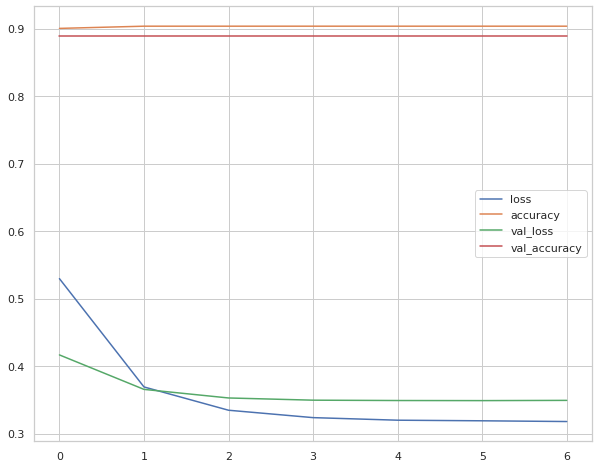

In [56]:
losses = pd.DataFrame(model.history.history)
losses.plot(figsize=(10,8))

In [57]:
model.evaluate(X_valid, y_valid)

4/4 [==============================] - 2s 344ms/step - loss: 0.3489 - accuracy: 0.8889


[0.3488771915435791, 0.8888888955116272]

In [58]:
# Predict the labels on validation dataset
y_pred = model.predict(X_valid).round()

# Gather scores
scores = classification_report(y_valid, y_pred, zero_division=0)
print(scores)

4/4 [==============================] - 2s 203ms/step
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        96
           1       0.00      0.00      0.00        12

   micro avg       0.89      0.89      0.89       108
   macro avg       0.44      0.50      0.47       108
weighted avg       0.79      0.89      0.84       108
 samples avg       0.89      0.89      0.89       108



**Computing** **Accuracy**

In [59]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy

In [61]:
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, y_pred)

0.8888888888888888